In [ ]:
import zipfile
import os
!pip install einops

zip_path = 'cnn_dataset.zip'
extract_path = 'cnn_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully.")

Dataset unzipped successfully.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
import os
import h5py
from torchsummary import summary
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
import torch.nn as nn
import random
from torchvision import models, transforms
from einops import rearrange

In [ ]:
dataset_path = 'cnn_dataset/cnn_dataset'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)


In [ ]:
num_classes = len(dataset.classes)
num_train = int(0.7 * len(dataset))
num_val = int(0.15 * len(dataset))
num_test = len(dataset) - num_train - num_val

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[num_train, num_val, num_test],
                                                        generator=torch.Generator().manual_seed(7))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## EfficientNet

In [ ]:
model = models.efficientnet_b0(pretrained=True)

num = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num, 3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = next(iter(train_loader))
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total +=  labels.size(0)
            correct +=  (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100*correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total +=  labels.size(0)
                correct +=  (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 93.88%  Train Loss: 0.17660874784513628  Validation Accuracy: 96.76%  Validation Loss: 0.0994213843114779
Epoch: 2  Train Accuracy: 96.96%  Train Loss: 0.09090144106818188  Validation Accuracy: 96.51%  Validation Loss: 0.10051496234446974
Epoch: 3  Train Accuracy: 98.16%  Train Loss: 0.05615454623942748  Validation Accuracy: 97.40%  Validation Loss: 0.08519361022872929
Epoch: 4  Train Accuracy: 98.59%  Train Loss: 0.04205677635107178  Validation Accuracy: 97.00%  Validation Loss: 0.08545086198342099
Epoch: 5  Train Accuracy: 98.73%  Train Loss: 0.03865560919763294  Validation Accuracy: 97.02%  Validation Loss: 0.09426219307843753


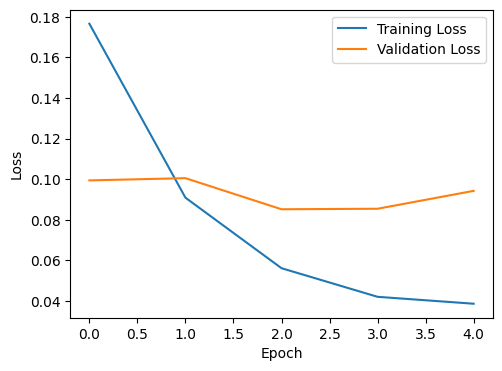

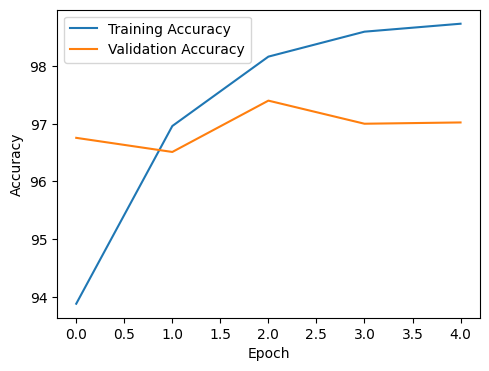

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

In [ ]:
#Test Accuracy and Loss
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))



In [ ]:
test_accuracy(model, test_loader)

Test Accuracy: 97 %
Test Loss: 0.08678862523667934


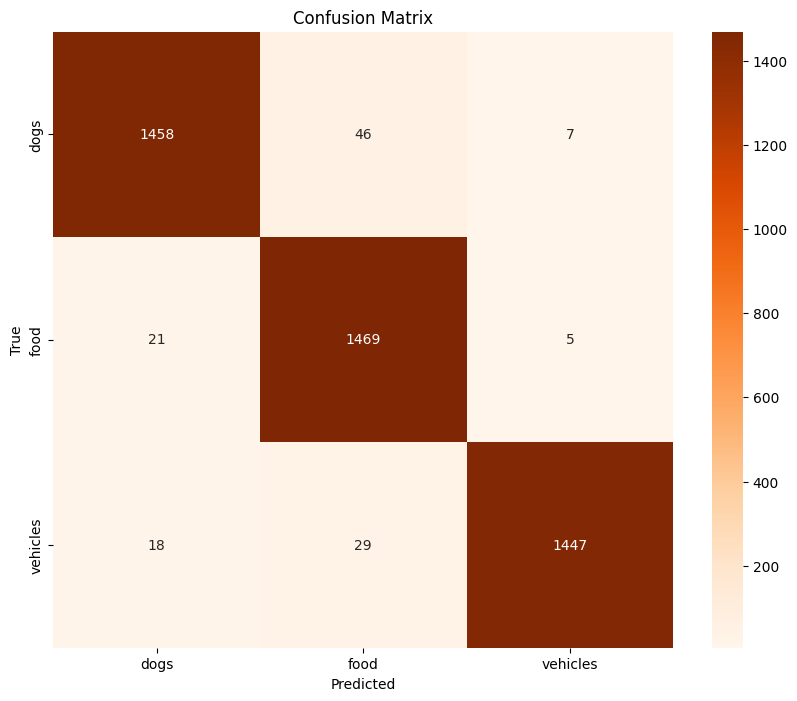

In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)


In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)

Precision: 0.97
Recall: 0.97
F1 Score: 0.97
